In [1]:
%matplotlib inline
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import boost_histogram as bh
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from lmfit.models import *
from lmfit import Model, Parameters

In [4]:
# read in reconstructed data
rec = pd.read_csv("yields_rga_exclusive.csv", index_col=False )
# rec = rec[(rec.mm2_exclusive.astype(float) > -0.4)]
# rec = rec[(rec.mm2_exclusive.astype(float) < 0.4)]
# rec = rec[(rec.pim_mom_mPim > 6)]
# rec = rec[(rec.pim_mom_mPim < 8)]


#rec['cos_theta'] = np.cos(rec.pip_theta).astype(np.float32)
rec.head()

,pim_mom_exclusive,pim_theta_exclusive,pim_phi_exclusive,mm2_exclusive,mm2_exclusive_at_zero
0,4.0,7.7,320.0,5.00,-0.3;
1,4.0,13.0,67.0,0.14,-0.056;
2,2.8,13.0,50.0,1.30,0.45;
3,6.5,4.5,2.4,3.60,1.4;
4,3.5,14.0,130.0,2.40,0.77;


No handles with labels found to put in legend.


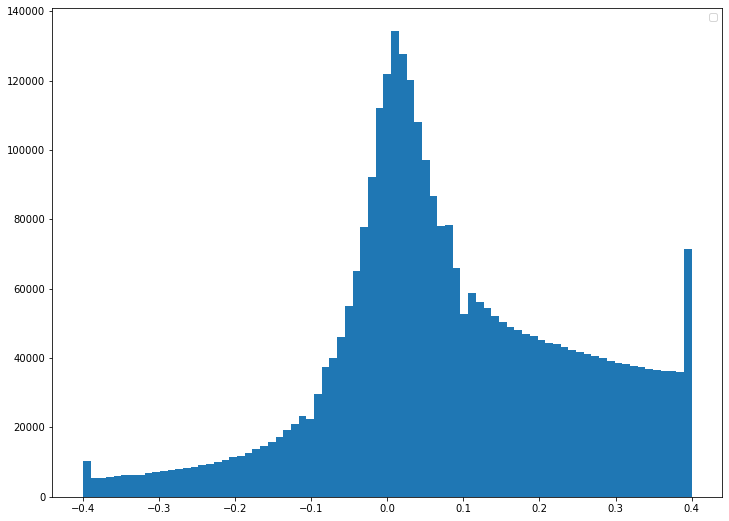

In [7]:

# plot W histogram

# Make a figure and axes to plot on
fig, ax = plt.subplots(figsize=(12,9))

#Plot hist on axes
# ax.hist(rec.mm2_mPim, bins=1, alpha=0.5, label='data', density=False, )
ax.hist(rec.mm2_exclusive.to_numpy(),bins=79, range=(-0.4,0.4), density=False)
# put legend on axes
ax.legend()
# plt.xlim(-0.4, 0.4)

# Show figure
fig.show()

In [11]:
# Create function to
import sys
from scipy import integrate

def mm_cut(df):
#     a = 0.0
    NSIGMA = 4
    cut_data = {}
#              s = str(mom_val)+'-'+str(mom_val+1)+'(GeV)''\u03B8 = (' + str(theta_val*18)+"-"+ str((theta_val+1)*18) +')\u00B0 and '+"\u03C6 = ("+str(phi_val*120)+'-'+str((phi_val+1)*120)+')\u00B0'
    # Seclect the data for the sector

    # Make a figure to plot on
    plt.figure(figsize=(12,9))
    # Histogram the data and 
    y, x = np.histogram( df.mm2_exclusive.to_numpy(), 
                                 bins=79, range=(-0.4,0.4), density=False)
    # here y, x is written because it plot the output as the x and y coordinates on a linegraph.
   
    # calculate bin centers
    x=(x[1:]+x[:-1])/2
#     print(x, y)
    # Plot points on
    plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)
    # Make a model with a peak
    peak = BreitWignerModel(prefix="peak_")
    pars = peak.make_params()
    # Set some parameters
    pars['peak_center'].set(value=0.1, min=-0.01, max=0.02)
#     pars['peak_sigma'].set(value=0.05, min=0.0, max=0.1)
    #pars['peak_amplitude'].set(value=0.5) 
    
    # Set the background
    background = PolynomialModel(2, prefix="back_")
#     pars_back = background.make_params()
#     pars_back['pars_back_c0'].set(value=0.1,min=0.)
    
    pars.update(background.guess(y, x=x))
    pars['back_c0'].set(value=0.1,min=0.)
#     print(pars)
                # Make full model to fit
    model = peak + background
        
                # Fit our full model
    out = model.fit(y, pars, x=x)

                # Make a more fine set of x's to plot with
    xs= np.linspace(-0.4, 0.4, 79)
#     print(xs, y) 
                # Plot our output model withe the new parameter and finer x's
    plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')
#     print(y, out.eval(x=xs))
                # Get the components of the fit for our finer x's
    comps = out.eval_components(x=xs)
#     print(comps['peak_'])
                # Plot just the peak component
    plt.plot(xs, comps['peak_'], 
                    'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

    plt.plot(xs, comps['back_'], 'r-',
                    label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
#                 Plot center +- sigma where we will cut later
    plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
    plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
                # Put on labels and show the plot
#                 plt.text(1, 1, 'phi_val = %1f ' % (phi_val))
#                 plt.text(0.5, 0.5, 'theta_val = %1f' % (theta_val))
    plt.title("MMSQ")
    xs=np.linspace(-0.06, 0.08, num = 14) # , retstep = True
    comps1 = out.eval_components(x=xs)
    total = integrate.simps(out.eval(x=xs))
    peak_out = integrate.simps(comps1['peak_'])
    background_out = integrate.simps(comps1['back_'])
    
#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     a +=out.eval(x=xs)
#     help(model.fit)
#     help(background.fit)
    print('total = ', total)
    print('signal = ', peak_out)
    print('background = ', background_out)
    print('ratio = ', peak_out/background_out)
#     print(out.eval(x=xs))

    print(out.fit_report(min_correl=0.5))
    plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
    plt.legend()
    plt.show()
        
# Save cut data to our
    cut_data = (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
            out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
            
        

    return cut_data

total =  1251520.7550009075
signal =  1037189.177618493
background =  214331.57738241483
ratio =  4.839180443150094
[[Model]]
    (Model(breit_wigner, prefix='peak_') + Model(polynomial, prefix='back_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 216
    # data points      = 79
    # variables        = 7
    chi-square         = 2.4289e+09
    reduced chi-square = 33735209.4
    Akaike info crit   = 1376.06040
    Bayesian info crit = 1392.64654
##  Warning: uncertainties could not be estimated:
    peak_center:     at initial value
    peak_center:     at boundary
[[Variables]]
    peak_amplitude:  46.6871593 (init = 1)
    peak_center:     0.02000000 (init = 0.02)
    peak_sigma:      0.11491995 (init = 1)
    peak_q:          48.7985933 (init = 1)
    back_c0:         15884.0021 (init = 0.1)
    back_c1:         52620.6867 (init = 64216.9)
    back_c2:         44290.1762 (init = -356616.3)


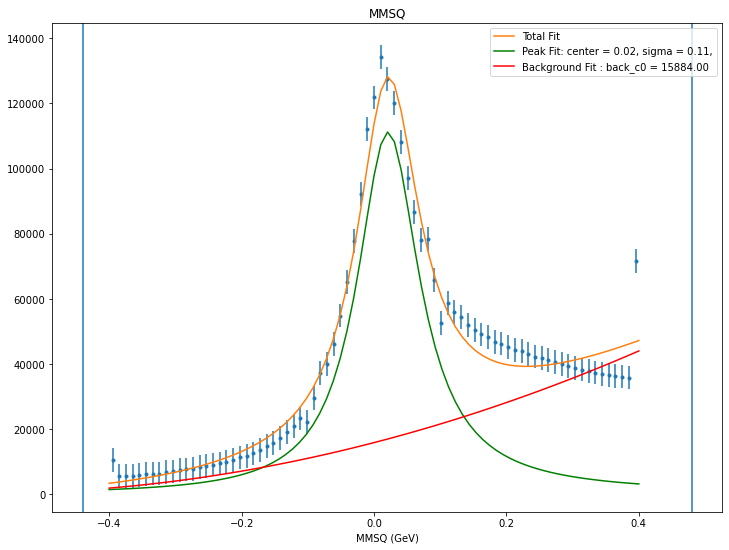

In [12]:
sector_cuts = mm_cut(rec)

In [193]:
# Create function to
import sys
from scipy import integrate
def mm_cut(df):
    NSIGMA = 4
    cut_data = {}
    
    # Makes a list from 0 to 10 spaced by 1
    mom_bin_ranges = np.arange(0,10, 5)
    # Cuts the mom data into the ranges from above
    rec['mom_bin'] = pd.cut(rec.pim_mom_exclusive, mom_bin_ranges)
    unique_mom = rec.mom_bin.unique()
    
    # Makes a list from 0 to 180 spaced by 18
    theta_bin_ranges = np.arange(0,180.1, 18)
    # Cuts the theta data into the ranges from above
    rec['theta_bin'] = pd.cut(rec.pim_theta_exclusive, theta_bin_ranges)
    unique_theta = rec.theta_bin.unique()
    
    # Makes a list from 0 to 360 spaced by 120
    phi_bin_ranges = np.arange(0,361, 120)
    # Cuts the phi data into the ranges from above
    rec['phi_bin'] = pd.cut(rec.pim_phi_exclusive, phi_bin_ranges)
    unique_phi = rec.phi_bin.unique()
    
    
    for mom in unique_mom:
        for theta in unique_theta:
            for phi in unique_phi:
#                 data = rec[rec.mom_bin == mom]
#                 data = rec[rec.theta_bin == theta]
                data = rec[rec.phi_bin == phi] 
                
#       The bin edges are saved as left and right
#         print(phi.left, phi.right)
                s = "MMSQ_\u03C6 = ("+str(phi.left)+'-'+str(phi.right)+')\u00B0' 
#  s = str(mom_val)+'-'+str(mom_val+1)+'(GeV)''\u03B8 = (' + str(theta_val*18)+"-"+ str((theta_val+1)*18) +')\u00B0 and '+"\u03C6 = ("+str(phi_val*120)+'-'+str((phi_val+1)*120)+')\u00B0'    


                # Make a figure to plot on
                plt.figure(figsize=(12,9))
                # Histogram the data and 
                y,x = np.histogram( data.mm2_exclusive.to_numpy(), 
                                 bins=79, range=(-0.4,0.4), density=False)
        
                # calculate bin centers
                x=(x[1:]+x[:-1])/2

                # Plot points on
                plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)

                # Make a model with a peak
                peak = BreitWignerModel(prefix="peak_")
                pars = peak.make_params()
                # Set some parameters
                pars['peak_center'].set(value=0, min=0.0, max=0.2)
                #pars['peak_sigma'].set(value=0.1, min=0.0, max=0.5)
                #pars['peak_amplitude'].set(value=0.5)
        
                # Set the background
                background =  PolynomialModel(2, prefix="back_")
                pars.update(background.guess(y, x=x))
                pars['back_c0'].set(value=0.1,min=0.)
        
                # Make full model to fit
                model = peak + background
        
                # Fit our full model
                out = model.fit(y, pars, x=x)
        
                # Make a more fine set of x's to plot with
                xs= np.linspace(-0.4, 0.4, 79)
        
                # Plot our output model withe the new parameter and finer x's
                plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')

                # Get the components of the fit for our finer x's
                comps = out.eval_components(x=xs)
                # Plot just the peak component
                plt.plot(xs, comps['peak_'], 
                    'g-', label=f"Peak Fit: center = {out.params['peak_center'].value:0.2f}, sigma = {out.params['peak_sigma'].value:0.2f},")

                plt.plot(xs, comps['back_'], 'r-',
                    label=f"Background Fit : back_c0 = {out.params['back_c0'].value:0.2f}")
                # Plot center +- sigma where we will cut later
                #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
                #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
                # Put on labels and show the plot
                plt.title(s)
                xs=np.linspace(-0.06, 0.08, num = 14) # , retstep = True
                comps1 = out.eval_components(x=xs)
                total = integrate.simps(out.eval(x=xs))
                peak_out = integrate.simps(comps1['peak_'])
                background_out = integrate.simps(comps1['back_'])
    
#                 f = background # lambda x:exp(-x**2)
#                 TotalInt = intg.quad(f, -0.1, 0.11)
#     a +=out.eval(x=xs)
#     help(model.fit)
#     help(background.fit)
                print('total = ', total)
                print('signal = ', peak_out)
                print('background = ', background_out)
                print('ratio = ', peak_out/background_out)
                plt.xlabel('MMSQ (GeV)')
#             plt.ylabel('Y')
                plt.legend()
                plt.show()
                print(mom)
                print(theta)
                print(phi)
            # Save cut data to our
                cut_data[mom][theta][phi]= (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                                out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
            
        

    return cut_data

total =  394072.8864574976
signal =  321909.4612272622
background =  72163.42523023541
ratio =  4.4608395485693615


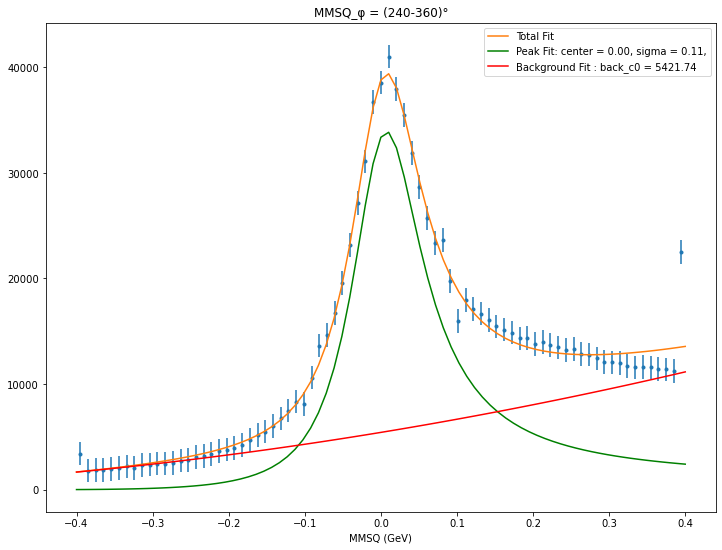

(0.0, 5.0]
(0.0, 18.0]
(240, 360]


KeyError: Interval(0.0, 5.0, closed='right')

In [194]:
sector_cuts = mm_cut(rec)

In [15]:
# rec.plot(kind='scatter',x='mmsq',y='bin_content')
# #rec.plot(kind='hist')
# plt.xlim(-0.30, 0.30)-
# plt.show()

In [338]:
import scipy.integrate
from numpy import exp
f= lambda x:exp(-x**2)
i = scipy.integrate.quad(f, 0, 1)
print (i)

(0.7468241328124271, 8.291413475940725e-15)


In [6]:
import csv
with open('first_100.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('yields_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        myDictionary = {columns[4]:columns[5] for columns in reader}
        print(myDictionary.values())

dict_values(['bin_content', '73', '6', '9', '4', '9', '14', '11', '12', '10', '17', '22', '17', '16', '18', '28', '15', '29', '26', '21', '38', '29', '30', '17', '29', '38', '42', '35', '62', '47', '64', '79', '62', '72', '70', '91', '74', '111', '106', '110', '139', '169', '186', '193', '243', '245', '320', '384', '495', '653', '868', '1345', '1927', '2837', '3102', '2709', '2208', '1709', '1459', '1260', '1119', '947', '904', '853', '790', '800', '694', '699', '620', '631', '649', '591', '572', '635', '538', '559', '534', '580', '509', '507', '466', '507', '457', '453', '415', '418', '385', '379', '372', '390', '334', '312', '344', '277', '292', '271', '280', '262', '227', '257', '250'])


In [7]:
with open('first_100.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('yields_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        myDictionary = {columns[4]:columns[5] for columns in reader}
        print(myDictionary.keys())

dict_keys(['mmsq', '-0.4', '-0.392', '-0.384', '-0.376', '-0.368', '-0.36', '-0.352', '-0.344', '-0.336', '-0.328', '-0.32', '-0.312', '-0.304', '-0.296', '-0.288', '-0.28', '-0.272', '-0.264', '-0.256', '-0.248', '-0.24', '-0.232', '-0.224', '-0.216', '-0.208', '-0.2', '-0.192', '-0.184', '-0.176', '-0.168', '-0.16', '-0.152', '-0.144', '-0.136', '-0.128', '-0.12', '-0.112', '-0.104', '-0.096', '-0.088', '-0.08', '-0.072', '-0.064', '-0.056', '-0.048', '-0.04', '-0.032', '-0.024', '-0.016', '-0.00799999', '1.30385E-08', '0.00800001', '0.016', '0.024', '0.032', '0.04', '0.048', '0.056', '0.064', '0.072', '0.08', '0.088', '0.096', '0.104', '0.112', '0.12', '0.128', '0.136', '0.144', '0.152', '0.16', '0.168', '0.176', '0.184', '0.192', '0.2', '0.208', '0.216', '0.224', '0.232', '0.24', '0.248', '0.256', '0.264', '0.272', '0.28', '0.288', '0.296', '0.304', '0.312', '0.32', '0.328', '0.336', '0.344', '0.352', '0.36', '0.368', '0.376', '0.384', '0.392'])


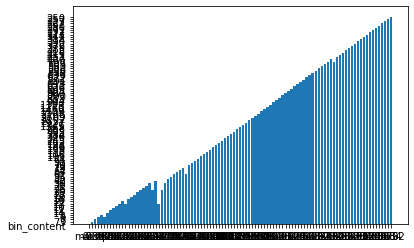

In [8]:
with open('first_100.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('yields_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        myDictionary = {columns[4]:columns[5] for columns in reader}
        plt.bar(list(myDictionary.keys()),myDictionary.values(),)
        plt.show()

No handles with labels found to put in legend.


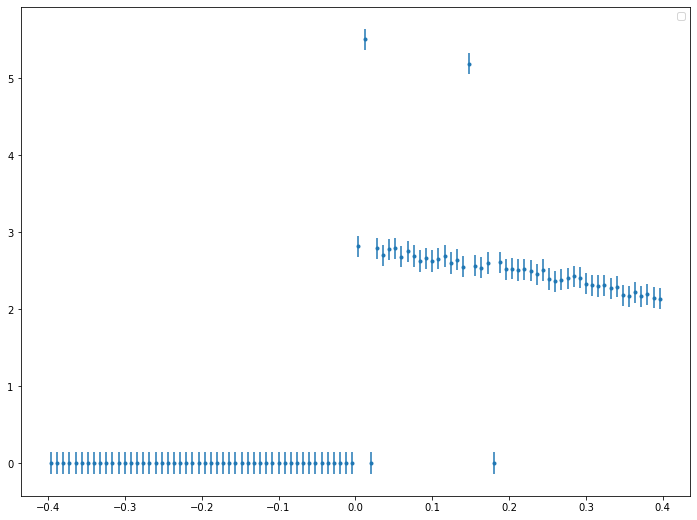

In [9]:
plt.figure(figsize=(12,9))
        
        # Histogram the data and 
y,x = np.histogram(rec.mmsq.to_numpy(), 
                                 bins=100, range=(-0.40,0.4), density=True)
        
        # calculate bin centers
x=(x[1:]+x[:-1])/2

        # Plot points on
plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)
           # Put on labels and show the plot
plt.legend()
plt.show()

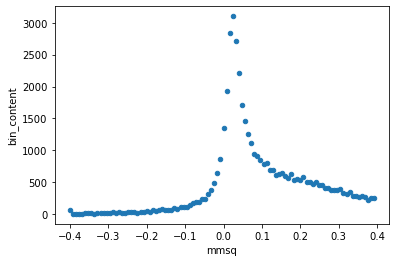

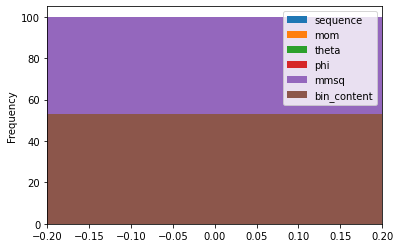

In [18]:
df  = pd.read_csv("first_100.csv")
df.plot(kind='scatter',x='mmsq',y='bin_content')
df.plot(kind='hist')
plt.xlim(-0.20, 0.20)
plt.show()

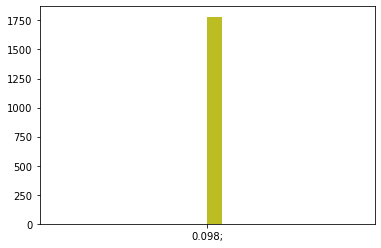

In [6]:
mom_val = {1, 2, 3, 5, 6, 7, 8, 9,10}
for i in mom_val:
#     if mom_val == int(rec.pim)
    plt.hist(rec.mm2_mPim,bins=20, range=(-0.20,0.2), density=False)
#     rec.plot(kind='scatter',x='mmsq',y='bin_content')
#     plt.xlim(-0.30, 0.30)

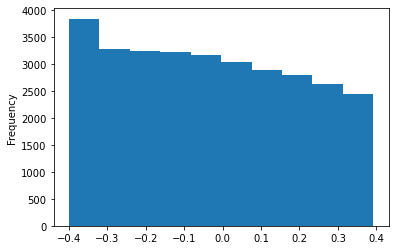

In [4]:
rec['mmsq'].plot(kind='hist');

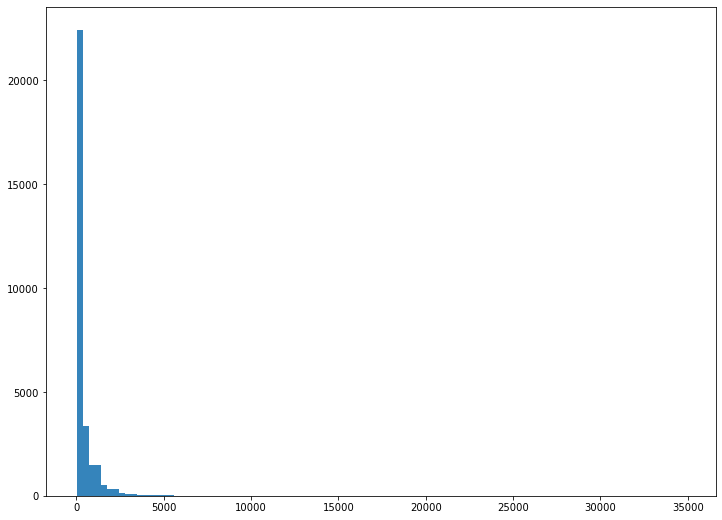

In [8]:

# plot W histogram

# Make a figure and axes to plot on
fig, ax = plt.subplots(figsize=(12,9))

# Plot hist on axes
ax.hist(rec.bin_content, bins=100, alpha=0.9, label='data', density=False, )

# put legend on axes
#ax.legend()

# Show figure
fig.show()

In [ ]:
x = [0,5,9,10,15]
y = [0,1,2,3,4]
plt.plot(x,y)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.show()

In [32]:
# Create function to 
def mm_cut(df):
    NSIGMA = 4
    cut_data = {}
    phi_val = {45, 90, 135, 180, 225, 270, 315, 360}
    for sec in phi_val:
        # Seclect the data for the sector
        data = df[df.phi == sec]
        # Make a figure to plot on
        plt.figure(figsize=(12,9))
        
        # Histogram the data and 
        y,x = np.histogram( df.bin_content, 
                                 bins=100, range=(-0.2,0.2), density=False)
        
        # calculate bin centers
        x=(x[1:]+x[:-1])/2

        # Plot points on
        plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', zorder=1)

        # Make a model with a peak
        peak = BreitWignerModel(prefix="peak_")
        pars = peak.make_params()
        # Set some parameters
        pars['peak_center'].set(value=1, min=0, max=1000)
        #pars['peak_sigma'].set(value=0.1, min=0.0, max=0.5)
        #pars['peak_amplitude'].set(value=0.5)
        
        # Set the background
        background =  PolynomialModel(5, prefix="back_")
        pars.update(background.guess(y, x=x))
        pars['back_c0'].set(value=0,min=0)
        
        # Make full model to fit
        model = peak + background
        
        # Fit our full model
        out = model.fit(y, pars, x=x)
        
        # Make a more fine set of x's to plot with
        xs= np.linspace(-0.2, 0.2, 100)
        
        # Plot our output model withe the new parameter and finer x's
        plt.plot(xs, out.eval(params=out.params, x=xs), label='Total Fit')

        # Get the components of the fit for our finer x's
        comps = out.eval_components(x=xs)
        # Plot just the peak component
        plt.plot(xs, comps['peak_'], 
                 alpha=0.4, label=f"Peak Fit {out.params['peak_center'].value:0.4f}")
        
        # Plot center +- sigma where we will cut later
        #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_sigma'])
        #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        
        # Put on labels and show the plot
        plt.legend()
        plt.show()
        
        # Save cut data to our
        cut_data [sec]= (out.params['peak_center']-NSIGMA*out.params['peak_sigma'], 
                     out.params['peak_center']+NSIGMA*out.params['peak_sigma'])
        

    return cut_data

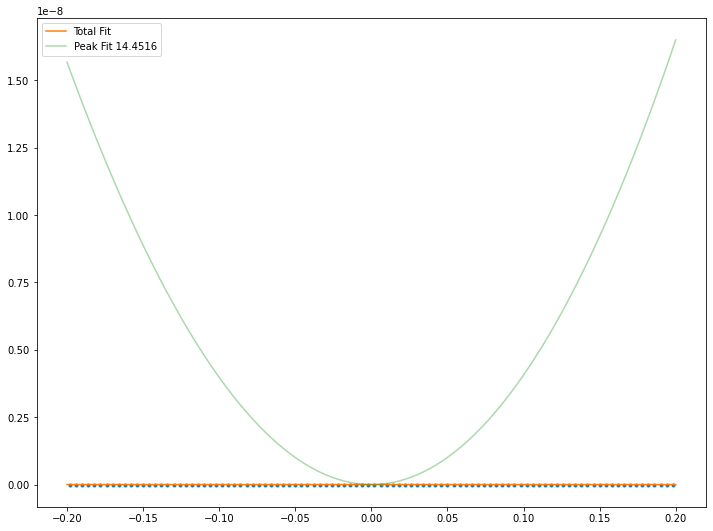

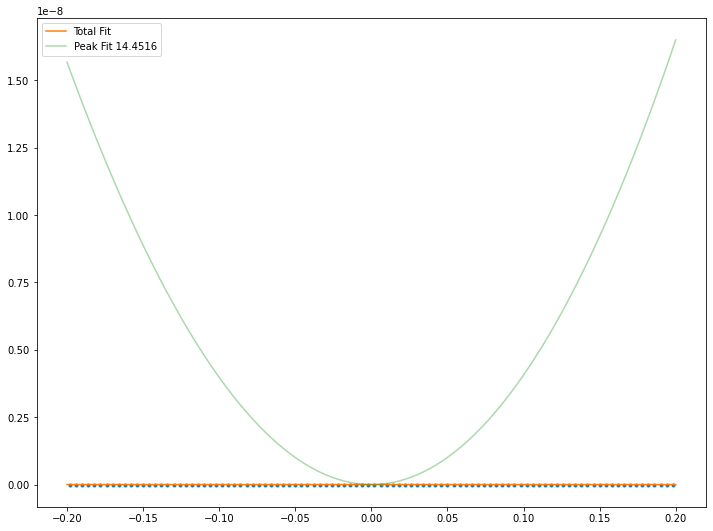

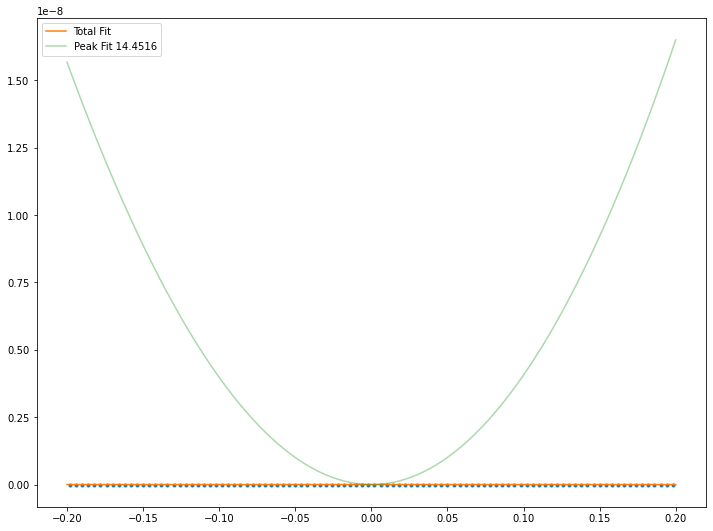

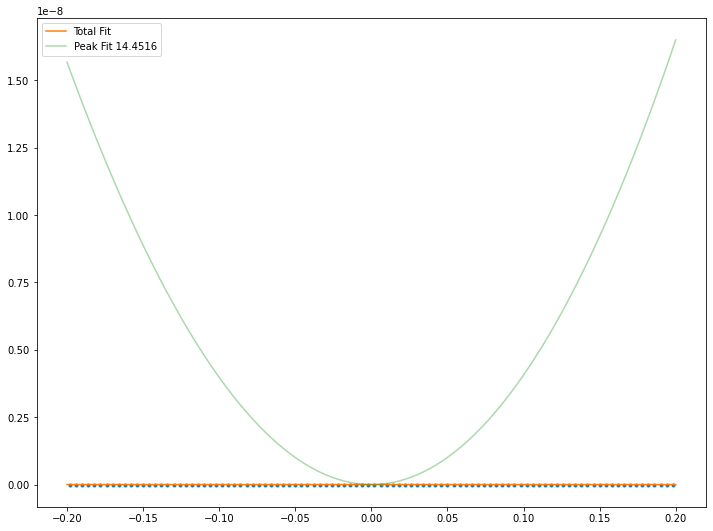

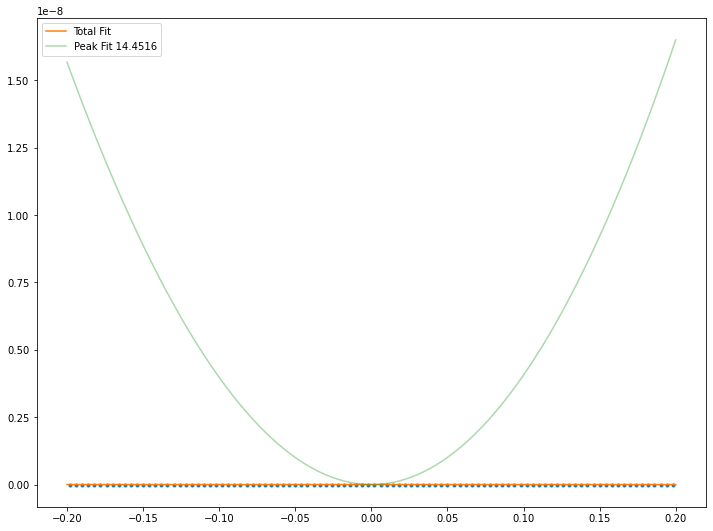

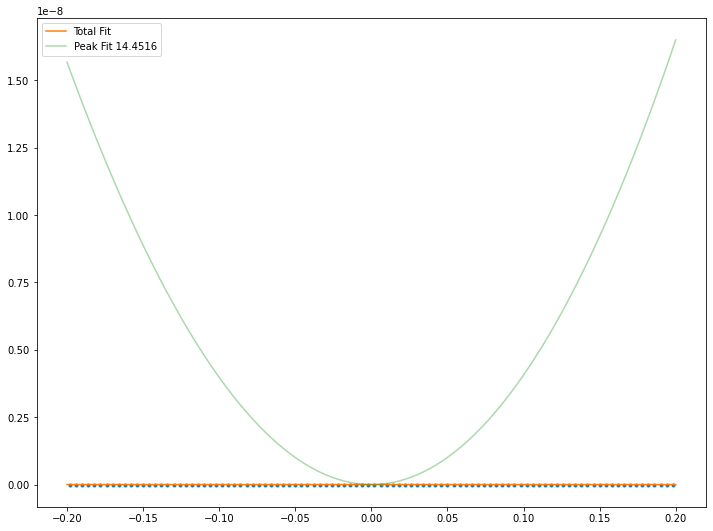

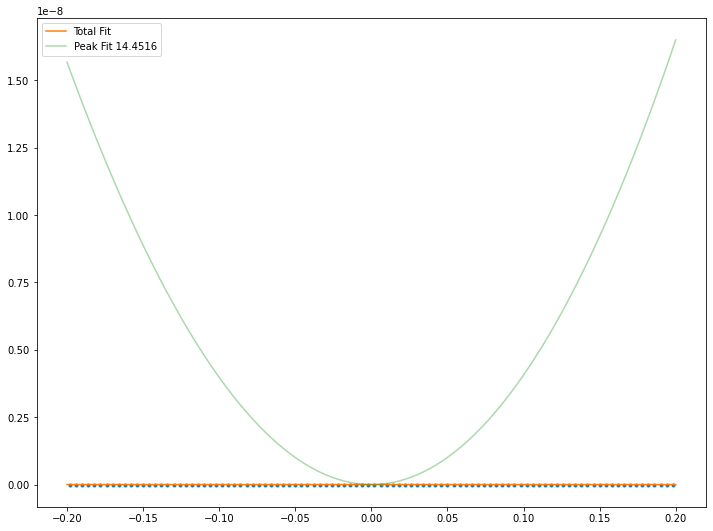

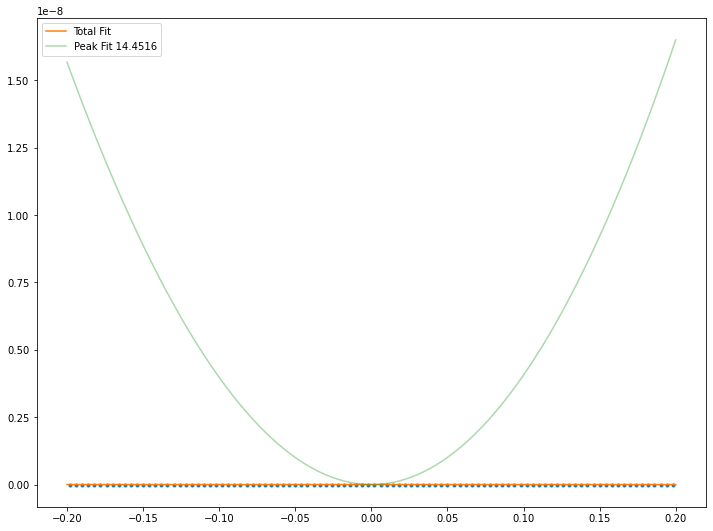

In [33]:
sector_cuts = mm_cut(rec)